In [1]:

from datetime import datetime
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('../All_data_with_exits.csv', 
                 parse_dates=['3.10 Enroll Date', '3.11 Exit Date', '3.917 Homeless Start Date'])
df = df[df['3.15 Relationship to HoH'] == 'Self']
df.shape

(576, 143)

In [3]:
JSON_STR_COLS = [
    '4.4 Covered by Health Insurance',
    '4.11 Domestic Violence - Currently Fleeing DV?', '3.6 Gender',
    '3.15 Relationship to HoH', '3.4 Race', '3.5 Ethnicity', 
    '4.10 Alcohol Abuse (Substance Abuse)', '4.06 Developmental Disability',
    '4.07 Chronic Health Condition', '4.10 Drug Abuse (Substance Abuse)',
    '4.08 HIV/AIDS', '4.09 Mental Health Problem', '4.05 Physical Disability',
    'R5 School Status'
]

df['4.2 Income Total at Entry'] = df['4.2 Income Total at Entry'].fillna(-1)
df[JSON_STR_COLS] = df[JSON_STR_COLS].fillna('')

In [4]:
clean = pd.DataFrame()

clean['family_id'] = df['5.9 Household ID']
clean['homeless_info.homeless_start_date'] = df['3.917 Homeless Start Date']
clean['insurance.has_insurance'] = df['4.4 Covered by Health Insurance']
clean['domestic_violence_info.fleeing_dv'] = df['4.11 Domestic Violence - Currently Fleeing DV?']

clean['id'] = df['5.8 Personal ID']
clean['date_of_enrollment'] = df['3.10 Enroll Date']
clean['household_type'] = df['Household Type']
clean['length_of_stay'] = (df['3.11 Exit Date'] - df['3.10 Enroll Date']).dt.days

clean['demographics.race'] = df['3.4 Race']
clean['demographics.ethnicity'] = df['3.5 Ethnicity']
clean['demographics.gender'] = df['3.6 Gender']
clean['demographics.relationship'] = df['3.15 Relationship to HoH']
clean['demographics.income'] = df['4.2 Income Total at Entry']

clean['barriers.HIV_AIDs'] = df['4.08 HIV/AIDS']
clean['barriers.alcohol_abuse'] = df['4.10 Alcohol Abuse (Substance Abuse)']
clean['barriers.drug_abuse'] = df['4.10 Drug Abuse (Substance Abuse)']
clean['barriers.chronic_health_issues'] = df['4.07 Chronic Health Condition']
clean['barriers.developmental_disabilities'] = df['4.06 Developmental Disability']
clean['barriers.mental_illness'] = df['4.09 Mental Health Problem']
clean['barriers.physical_disabilities'] = df['4.05 Physical Disability']

clean['schools.enrolled_status'] = df['R5 School Status']
clean['case_members'] = df['CaseMembers']

# clean['birth_year'] = (df['3.10 Enroll Date'].dt.year - df['Age at Enrollment'])
# clean['inc_earned'] = df['4.2.3a Earned Income']
# clean['inc_unemployement'] = df['4.2.4b Unemployment Insurance']
# clean['inc_ss_disabil'] = df['4.2.6d Social Security Disability  Income']
# clean['inc_tanf'] = df['4.2.11i TANF']
# clean['inc_child_sup'] = df['4.2.15m Child Support']
# clean['school'] = df['R5 School Status']
# clean['highest_grade'] = df['R4 Last Grade Completed']
# clean['times_homeless_3y'] = df['3.917 Times Homeless Last 3 Years']
# clean['tot_months_homeless_3y'] = df['3.917 Total Months Homeless Last 3 Years']
# clean['pregnancy'] = df['R10 Pregnancy Status']
# clean['preg_due_date'] = df['R10 Pregnancy Due Date']


clean['exit_dest'] = df['3.12 Exit Destination'].replace({
    #### THIS DICT FROM "Data Exploration" NOTEBOOK
    
    # Permanent Exits
    'Staying or living with family, permanent tenure' : 'Permanent Exit',
    'Staying or living with friends, permanent tenure' : 'Permanent Exit',
    'Permanent housing (other than RRH) for formerly homeless persons' : 'Permanent Exit',
    'Rental by client with RRH or equivalent subsidy' : 'Permanent Exit',
    'Rental by client, no ongoing housing subsidy' : 'Permanent Exit',
    'Rental by client, other ongoing housing subsidy' : 'Permanent Exit',
    'Owned by client, no ongoing housing subsidy' : 'Permanent Exit',
    
    # Temporary Exits
    'Staying or living with family, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    'Staying or living with friends, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    
    # Emergency Shelter
    'Emergency shelter, including hotel or motel paid for with emergency shelter voucher, or RHY-funded Host Home shelter' : 'Emergency Shelter',
   
    # Transitional Housing
    'Transitional Housing for homeless persons (including homeless youth)' : 'Transitional Housing',
    'Safe Haven' : 'Transitional Housing',
    'Substance Abuse Treatment or Detox Center' : 'Transitional Housing',
    'Foster Care Home or Foster Care Group Home' : 'Transitional Housing',
    'Psychiatric Hospital or Other Psychiatric Facility' : 'Transitional Housing',
   
    # Unknown/Other
    'Hotel or Motel paid for without Emergency Shelter Voucher' : 'Unknown/Other',
    'Place not meant for habitation (e.g., a vehicle, an abandoned building, bus/train/subway station/airport or anywhere outside)' : 'Unknown/Other',
    'No exit interview completed' : 'Unknown/Other',
    'Client refused' : 'Unknown/Other',
    'Other' : 'Unknown/Other',
    'Client doesn\'t know' : 'Unknown/Other',
    np.NaN : 'Unknown/Other'
})


def _feat_engineer(df):
    df = df.copy()

    df['homeless_start_year'] = df['homeless_info.homeless_start_date'].dt.year
    df['homeless_start_doy'] = df['homeless_info.homeless_start_date'].dt.dayofyear

    df['year_of_enrollment'] = df['date_of_enrollment'].dt.year
    df['doy_of_enrollment'] = df['date_of_enrollment'].dt.dayofyear

    df = df.drop(columns=['homeless_info.homeless_start_date', 
                          'date_of_enrollment', 'id', 'family_id'])

    return df[sorted(df.columns)]

clean = _feat_engineer(clean)
clean.shape

(576, 23)

In [5]:

import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix


In [6]:

X = clean.drop(columns=['exit_dest'])
y = clean['exit_dest']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=.2)


In [7]:
y.value_counts(normalize=True)

Unknown/Other           0.368056
Permanent Exit          0.307292
Emergency Shelter       0.217014
Temporary Exit          0.059028
Transitional Housing    0.048611
Name: exit_dest, dtype: float64

In [8]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=1)
)

cross_val_score(model, X, y, cv=20, n_jobs=-1).mean()

0.4567118226600986

In [9]:
model.fit(Xt, yt)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['barriers.HIV_AIDs',
                                      'barriers.alcohol_abuse',
                                      'barriers.chronic_health_issues',
                                      'barriers.developmental_disabilities',
                                      'barriers.drug_abuse',
                                      'barriers.mental_illness',
                                      'barriers.physical_disabilities',
                                      'demographics.ethnicity',
                                      'demographics.gender',
                                      'demographics.race',
                                      'demographics.relationship',
                                      'do...
Household with Only Children          3
NaN                                  -2
dtype: int64},
                                         {'col': 'insurance.has_insurance',
                            

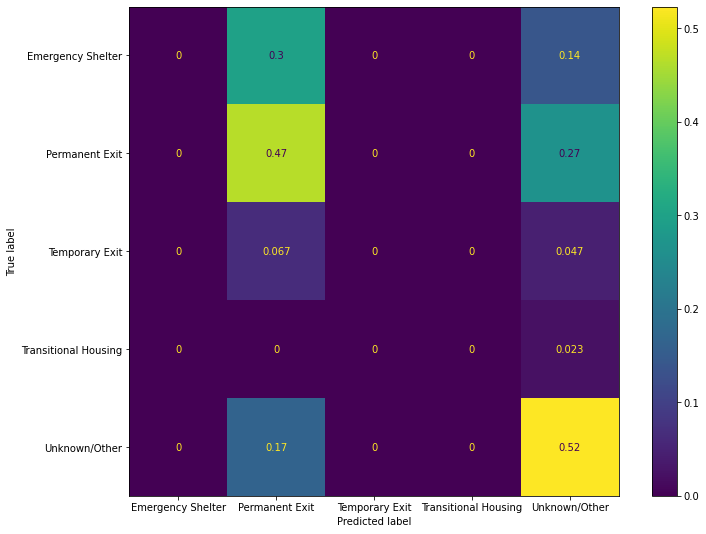

In [10]:
fig, ax = plt.subplots(figsize=[12,9])
plot_confusion_matrix(model, Xv, yv, normalize='pred', ax=ax);

In [11]:
pd.Series(model.named_steps['decisiontreeclassifier'].feature_importances_, index=X.columns).sort_values(ascending=False)

length_of_stay                         1.0
year_of_enrollment                     0.0
demographics.gender                    0.0
barriers.alcohol_abuse                 0.0
barriers.chronic_health_issues         0.0
barriers.developmental_disabilities    0.0
barriers.drug_abuse                    0.0
barriers.mental_illness                0.0
barriers.physical_disabilities         0.0
case_members                           0.0
demographics.ethnicity                 0.0
demographics.income                    0.0
schools.enrolled_status                0.0
demographics.race                      0.0
demographics.relationship              0.0
domestic_violence_info.fleeing_dv      0.0
doy_of_enrollment                      0.0
homeless_start_doy                     0.0
homeless_start_year                    0.0
household_type                         0.0
insurance.has_insurance                0.0
barriers.HIV_AIDs                      0.0
dtype: float64

In [14]:
import pickle

model.fit(X, y)

pickle.dump(model, open('../tree3.pickle', 'wb'))